In [1]:
import pandas as pd
import numpy as np
import re

/Users/ariankalantari/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Exploratory Data Analysis

We first need to explore the dataset to find some patterns or some improvements we could possibly make when manupilating the data. This will help us work with appropreately cleaned data, and dive deeper to extract insights.

## Loading Dataset

In [2]:
df = pd.read_csv('data/scraped_data.csv')
len(df)

3925

In [3]:
df[0:4]

,posted_date,is_verified,comment,aircraft,traveller_type,cabin_class,route,flight_date,seat_comfort_rating,cabin_staff_service_rating,food_and_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_and_connectivity_rating,value_for_money_rating,is_recommended
0,2025-03-31,Not Verified,Not Verified| Very good service on this route...,A320,Couple Leisure,Business Class,London Gatwick to Fuerteventura,March 2025,4.0,5.0,5.0,NaN,4.0,NaN,4.0,yes
1,2025-03-19,Trip Verified,✅Trip Verified| Flight mainly let down by a ...,Boeing 787,Solo Leisure,Business Class,Cape Town to London,March 2025,5.0,2.0,5.0,5.0,4.0,1.0,4.0,yes
2,2025-03-16,Trip Verified,✅Trip Verified| Another awful experience by ...,NaN,Business,Business Class,London to Geneva,December 2024,1.0,1.0,NaN,NaN,1.0,NaN,1.0,no
3,2025-03-16,Trip Verified,"✅Trip Verified| The service was rude, full o...",NaN,Business,Premium Economy,London to New York,January 2025,1.0,1.0,1.0,NaN,5.0,NaN,1.0,no


From the look of the dataset, we can see some possibility of improvements:

- route can be divided into departing_location and arrival_location
- is_verified could be binary (yes = 1, no = 0)
- is_recommended could be binary (yes = 1, no = 0)

We can first make some data manupilation on above. Let's get started.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    1611 non-null   object 
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [5]:
df.route.value_counts()

route
London to Johannesburg          21
Vancouver to London             17
Johannesburg to London          17
London to Hong Kong             15
London to Cape Town             15
                                ..
London Heathrow to Houston       1
London to Gibraltar              1
London Heathrow to Bengaluru     1
London City to Zurich            1
BOM-LHR                          1
Name: count, Length: 1637, dtype: int64

In [6]:
departures = []
arrivals = []
vias = []

def parse_route(route):
    if not isinstance(route, str):
        departures.append(None)
        arrivals.append(None)
        vias.append(None)
        return
    
    # Case 1: With via
    if 'via' in route:
        pattern = r'^(.*) to (.*) via (.*)$'
        match = re.match(pattern, route)
        if match:
            departure, arrival, via = match.groups()
            departures.append(departure.strip())
            arrivals.append(arrival.strip())
            vias.append(via.strip())
            return
    
    # Case 2: Direct
    elif 'to' in route:
        pattern = r'^(.*) to (.*)$'
        match = re.match(pattern, route)
        if match:
            departure, arrival = match.groups()
            departures.append(departure.strip())
            arrivals.append(arrival.strip())
            vias.append(None)
            return
    
    # Case 3: Unrecognizable format
    departures.append(None)
    arrivals.append(None)
    vias.append(None)

for route in df.route:
    parse_route(route)

print(len(departures))
print(len(arrivals))
print(len(vias))

3925
3925
3925


In [7]:
df["departure"] = departures
df["arrivals"] = arrivals
df["via"] = vias

In [8]:
# is_verified can be converted into binary value.
df.is_verified = df.is_verified.fillna(0)
df.is_verified = np.where(df['is_verified'] == 'Trip Verified', 1, 0)

df.is_verified

0       0
1       1
2       1
3       1
4       1
       ..
3920    0
3921    0
3922    0
3923    0
3924    0
Name: is_verified, Length: 3925, dtype: int64

In [9]:
# is_recommended can be converted into binary value.
df.is_recommended = np.where(df['is_recommended'] == 'yes', 1, 0)

df.is_recommended

0       1
1       1
2       0
3       0
4       0
       ..
3920    1
3921    1
3922    1
3923    0
3924    0
Name: is_recommended, Length: 3925, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [12]:
df[df["traveller_type"].isnull()]

,posted_date,is_verified,comment,aircraft,traveller_type,cabin_class,route,flight_date,seat_comfort_rating,cabin_staff_service_rating,food_and_beverages_rating,inflight_entertainment_rating,ground_service_rating,wifi_and_connectivity_rating,value_for_money_rating,is_recommended,departure,arrivals,via
287,2023-09-01,1,✅Trip Verified| British Airways absolutely do...,Boeing 777,NaN,Economy Class,Los Angeles to London,August 2023,1.0,1.0,1.0,1.0,1.0,NaN,1.0,0,Los Angeles,London,None
565,2022-07-13,1,✅Trip Verified| Over 1 week ago I cancelled 2...,NaN,NaN,Business Class,London to Malaga,July 2022,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0,London,Malaga,None
2089,2017-01-26,0,✅Verified Review| London Heathrow to Chicago ...,NaN,NaN,First Class,LHR to ORD,January 2017,2.0,3.0,2.0,3.0,2.0,NaN,2.0,0,LHR,ORD,None
3157,2015-06-07,0,Travelled from Venice to Gatwick on 28th May c...,NaN,NaN,Business Class,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,1.0,0,None,None,None
3158,2015-06-07,0,Worst customer experience on BA flight. I have...,NaN,NaN,Economy Class,NaN,NaN,1.0,1.0,2.0,2.0,NaN,NaN,1.0,0,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3920,2012-08-29,0,YYZ to LHR - July 2012 - I flew overnight in p...,NaN,NaN,Premium Economy,NaN,NaN,4.0,3.0,3.0,4.0,NaN,NaN,4.0,1,None,None,None
3921,2012-08-28,0,LHR to HAM. Purser addresses all club passenge...,NaN,NaN,Business Class,NaN,NaN,4.0,5.0,4.0,NaN,NaN,NaN,3.0,1,None,None,None
3922,2011-10-12,0,My son who had worked for British Airways urge...,NaN,NaN,Economy Class,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1,None,None,None
3923,2011-10-11,0,London City-New York JFK via Shannon on A318 b...,NaN,NaN,Premium Economy,NaN,NaN,1.0,3.0,5.0,NaN,NaN,NaN,1.0,0,None,None,None


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3798 non-null   float64
 9   cabin_staff_service_rating     3783 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

There seems to be many missing values in below columns:

- aircraft (roughly 2000)
- traveller_type (roughly 800)
- cabin_class (2)
- route (roughly 800)
- flight_date (roughly 800)
- seat_comfort_rating (roughly 200)
- cabin_staff_service_rating (roughly 800)
- food_and_beverages_rating (roughly 500)
- inflight_entertainment_rating (roughly 1400)
- ground_service_rating (roughly 900)
- wifi_and_connectivity_rating (roughly 3300)
- value_for_money_rating (1) 

We can compute the percentage of missing values per column below:

In [29]:
for col in df.columns:
    ratio = df[col].isnull().sum()/len(df)
    ratio = round(ratio,2) * 100
    print(f"{col}: {ratio}%")

posted_date: 0.0%
is_verified: 0.0%
comment: 0.0%
aircraft: 48.0%
traveller_type: 20.0%
cabin_class: 0.0%
route: 20.0%
flight_date: 20.0%
seat_comfort_rating: 3.0%
cabin_staff_service_rating: 4.0%
food_and_beverages_rating: 11.0%
inflight_entertainment_rating: 32.0%
ground_service_rating: 22.0%
wifi_and_connectivity_rating: 82.0%
value_for_money_rating: 0.0%
is_recommended: 0.0%
departure: 20.0%
arrivals: 20.0%
via: 86.0%


We have to decide if filling those missing values make sense or not. 

1. seat_comfort_rating, cabin_staff_service_rating can be filled with the median rate.
2. traveller_type can be filled with "Not Verified" as removing these values could remove important information from comments etc.
3. 


In [36]:
# Replacing NaN for seat_comfort_rating, cabin_staff_service_rating with median rate.
seat_comfort_rating_median = df.seat_comfort_rating.median()
cabin_staff_service_rating_median = df.cabin_staff_service_rating.median()

df.seat_comfort_rating = df.seat_comfort_rating.fillna(seat_comfort_rating_median)
df.cabin_staff_service_rating = df.cabin_staff_service_rating.fillna(cabin_staff_service_rating_median)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3154 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3925 non-null   float64
 9   cabin_staff_service_rating     3925 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [40]:
df.cabin_staff_service_rating.describe()

count    3925.000000
mean        3.222930
std         1.467967
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         5.000000
Name: cabin_staff_service_rating, dtype: float64

In [46]:
print(df.traveller_type.unique())

df.traveller_type.describe()

['Couple Leisure' 'Solo Leisure' 'Business' 'Family Leisure' nan]


count               3154
unique                 4
top       Couple Leisure
freq                1063
Name: traveller_type, dtype: object

There are 2 x ways to fill these missing values in traveller_type column. One is using mode (frequent value) and the other is using random vaslue based on exisiting value (traveller_type distribution), and this time we are going for simpler imputation option, that is replacing NaN with mode.

Note that this imputation could be biased as we are not introducing any randomness, however in the sense of replication, this is better and the easier option.



In [64]:
traveller_type_mode = df.traveller_type.mode()[0]

traveller_type_mode

df.traveller_type = df.traveller_type.fillna(traveller_type_mode)

In [66]:
df.aircraft = df.aircraft.fillna("Unknown")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       3925 non-null   object 
 4   traveller_type                 3925 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3925 non-null   float64
 9   cabin_staff_service_rating     3925 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3925 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3925 non-null   object 
 1   is_verified                    3925 non-null   int64  
 2   comment                        3925 non-null   object 
 3   aircraft                       2045 non-null   object 
 4   traveller_type                 3925 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3149 non-null   object 
 7   flight_date                    3147 non-null   object 
 8   seat_comfort_rating            3925 non-null   float64
 9   cabin_staff_service_rating     3925 non-null   float64
 10  food_and_beverages_rating      3485 non-null   float64
 11  inflight_entertainment_rating  2670 non-null   float64
 12  ground_service_rating          3075 non-null   f

In [67]:
df.dropna(subset=["cabin_class"], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3923 entries, 0 to 3924
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   posted_date                    3923 non-null   object 
 1   is_verified                    3923 non-null   int64  
 2   comment                        3923 non-null   object 
 3   aircraft                       3923 non-null   object 
 4   traveller_type                 3923 non-null   object 
 5   cabin_class                    3923 non-null   object 
 6   route                          3148 non-null   object 
 7   flight_date                    3146 non-null   object 
 8   seat_comfort_rating            3923 non-null   float64
 9   cabin_staff_service_rating     3923 non-null   float64
 10  food_and_beverages_rating      3483 non-null   float64
 11  inflight_entertainment_rating  2668 non-null   float64
 12  ground_service_rating          3074 non-null   float6

Some ratings are still missing values ranging from 500 to 1300. we need to check if that is because the rating review was introduced after certain year or is because the service availability.

In [104]:
df['flight_date_parsed'] = pd.to_datetime(df['flight_date'], format='%B %Y', errors='coerce')
df['flight_year'] = df['flight_date_parsed'].dt.year
df['flight_month'] = df['flight_date_parsed'].dt.month_name()

In [105]:
df['posted_date_parsed'] = pd.to_datetime(df['posted_date'], format='%Y-%m-%d', errors='coerce')

df['posted_year'] = df['posted_date_parsed'].dt.year

In [110]:
test = df[['posted_year', 'flight_year']]
sum(test.posted_year == test.flight_year)

2943

In [111]:
test.posted_year == test.flight_year

0        True
1        True
2       False
3        True
4        True
        ...  
3920    False
3921    False
3922    False
3923    False
3924    False
Length: 3923, dtype: bool

In [113]:
test.isnull().sum()

posted_year      0
flight_year    777
dtype: int64

In [114]:
777 + 2943

3720

In [115]:
test.posted_year

0       2025
1       2025
2       2025
3       2025
4       2025
        ... 
3920    2012
3921    2012
3922    2011
3923    2011
3924    2011
Name: posted_year, Length: 3923, dtype: int32

Let's talk about flight_year. We can see that there are about 20% datapoints missing, and dropping these many rows is not good. As most reviews are written soon after flying, we could use posted_year as a reliable proxy.

Now using this posted_year we can carry out time series analysis on missing ratings to see if those are because of service availability or questionare update.

Let's go!!!

In [117]:
import matplotlib.pyplot as plt

def plot_missingness_by_year(df, column, date_col='posted_year'):
    missing_by_year = (
        df.groupby(date_col)[column]
        .apply(lambda x: x.isna().mean() * 100)
        .sort_index()
    )

    plt.figure(figsize=(10, 5))
    missing_by_year.plot(kind='bar', title=f"% Missing '{column}' by {date_col}", ylabel='% Missing', xlabel='Year')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


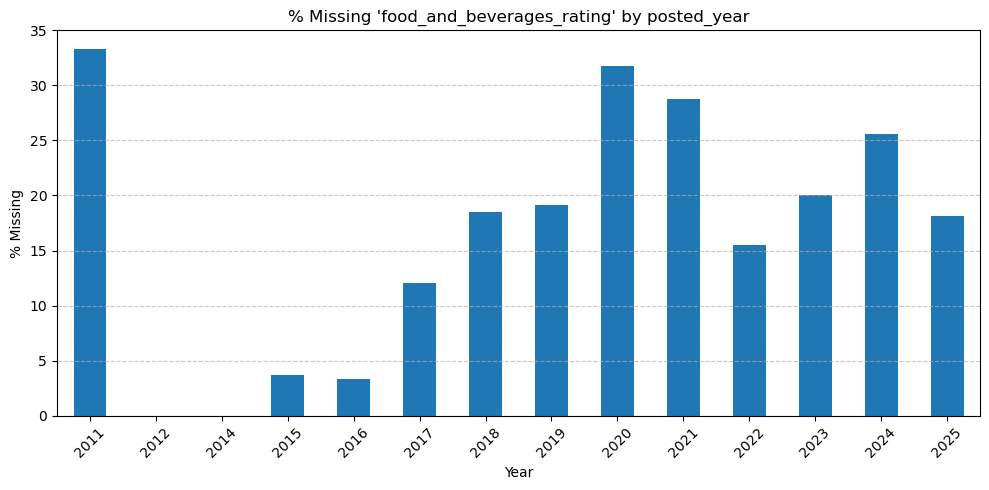

In [118]:
plot_missingness_by_year(df, 'food_and_beverages_rating')

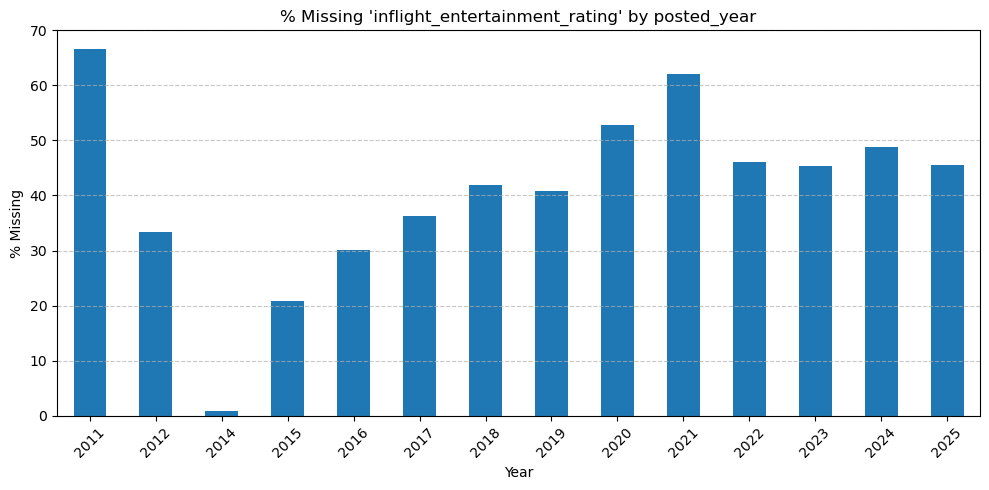

In [119]:
plot_missingness_by_year(df, 'inflight_entertainment_rating')

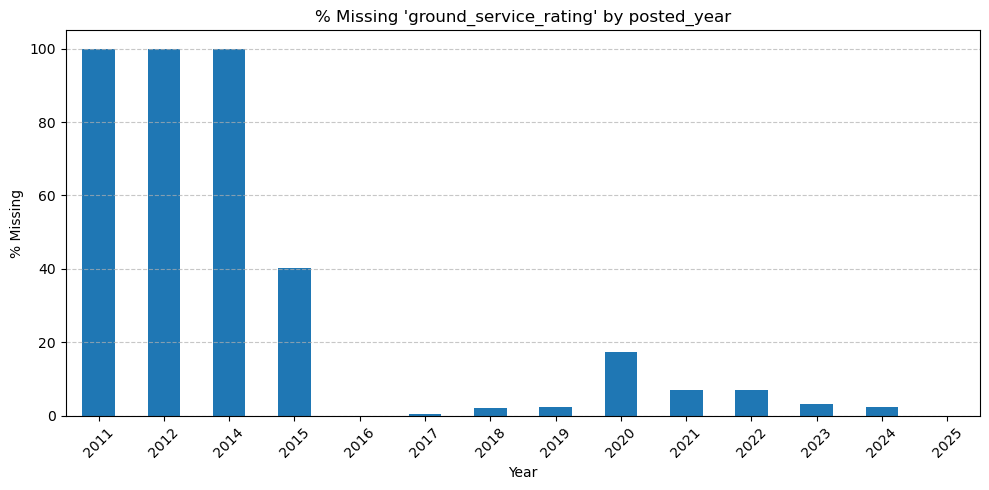

In [121]:
plot_missingness_by_year(df, 'ground_service_rating')